# Play with k8s cluster using python

- __Installation__
  * pip
  * kubernetes
  * pandas (Only needed for cluster data analysis)
  * k8sclient (wrapper for kubernetes)


- __Collect cluster information and data analysis with pandas__
  * setup
  * pod
  * node
  * service
  * etc.
 
  
- __Deploy pod/replicaset/service and some simple usage/test__
  * pods, volume, service and etc.
  * replicaset
  * network connectivity test
  * file system test (fio), network throughput (iperf), pod stress test and etc
  * service search
  * query api (hubot)

## Installation
#### [pip](https://pip.pypa.io/en/stable/installing/)
>Be cautious if you're using a Python install that's managed by your operating system or another package manager. get-pip.py does not coordinate with those tools, and may leave your system in an inconsistent state.
>To install pip via package manager, use package name python-pip
>Python3 is recommented though, not sure thoes numpy/pandas package can work well with python3

```shell
wget https://bootstrap.pypa.io/get-pip.py
python get-pip.py
```

#### [kubernetes](https://github.com/kubernetes-incubator/client-python/)
```shell
pip install kubernetes
```
> Usefully documentation links 
   * [auto generated docs](https://github.com/kubernetes-incubator/client-python/blob/master/kubernetes/README.md)
   * [api references](https://kubernetes.io/docs/api-reference/v1.6/)


#### [pandas](pandas.pydata.org/pandas-docs/stable/)
```shell
pip install pandas
```

#### k8sclient
```shell
git clone ssh://git@10.19.248.200:30884/DavidWang/k8sft.git
cd k8sft && pip install -e .
```

## Collect cluster information

### notebook setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

### Pod information

In [2]:
# raw pod 
from k8sclient.K8SClient import k8sclient
# k8sclient.get_pod_info("cc-template", "logger-heavy-4148218366-3csfq")

#### all pods under specific namespace

In [4]:
from k8sclient.dataframes import collect_namespaced_pods
dfs = collect_namespaced_pods("cc-demo")
# dfs['pod']

In [11]:
containers = pd.merge(dfs['pod'], dfs['container'], left_on="uid", right_on="pod_id")
containers[['rmemory', 'rcpu', 'lmemory', 'lcpu']].sum()

rmemory    4.03125
rcpu       4.20000
lmemory    4.03125
lcpu       4.20000
dtype: float64

#### collect all pods information

In [3]:
from k8sclient.dataframes import collect_all_pods
pods = collect_all_pods()

In [8]:
cs = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
cs[cs['privileged']][['host_network', 'host_ip', 'namespace', 'node_name', 'pod']]

,host_network,host_ip,namespace,node_name,pod
7,None,10.19.137.157,4tools,10.19.137.157,mongodb-deploy-977f7559d-6rtgx
8,None,10.19.140.15,4tools,10.19.140.15,pritunl-deploy-v2-7b6459c8d-7w28n
56,None,10.19.138.179,cc-dev,10.19.138.179,cc-storage-795bcbc8d4-gsbjb
96,True,10.19.138.67,cc-itg,10.19.138.67,cc-storage-6545dfc486-rz9s6
166,True,10.19.140.9,cc-stage,10.19.140.9,cc-storage-dfdcdb754-wtdvv
219,True,10.19.137.143,ceph,10.19.137.143,osd-143-sdb-8967cbb6c-fdplx
220,True,10.19.137.144,ceph,10.19.137.144,osd-144-sdb-8ffd56b85-d7zrk
221,True,10.19.137.145,ceph,10.19.137.145,osd-145-sdb-6ddff8ffbb-rwt72
222,True,10.19.137.146,ceph,10.19.137.146,osd-146-sdb-7f5d69bcf4-hkswf
223,True,10.19.137.152,ceph,10.19.137.152,osd-152-sdb-55b4c74459-zwpt7


In [32]:
p = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
v = p.set_index('ctime').sort_index()[['namespace', 'rmemory', 'rcpu']]
exclude = ['4tools', 'cc-dev', 'ceph', 'monitor-essential-service', 'shared-hdfs', 'monitor-system-alert', 'system-tools', 'kube-system']
v = v[~v.namespace.isin(exclude)]
v[v.index < pd.Timestamp('2018-03-1')].groupby('namespace').sum().sort_values(by='rcpu', ascending=False).sum()

rmemory    56.524902
rcpu       29.500000
dtype: float64

In [70]:
 p = pods['pod']# .groupby(['qos_class']).size()
p[p.qos_class == 'BestEffort']

,annotations,cluster_name,ctime,dns_policy,host_ip,host_ipc,host_network,host_pid,namespace,node_name,phase,pod,pod_ip,qos_class,restart_policy,stime,uid
201,kubernetes.io/config.hash=c99cdb1f3d83977a1611...,None,2018-01-19 08:58:36+00:00,ClusterFirst,10.19.138.67,None,True,None,haproxy,10.19.138.67,Running,haproxy-10.19.138.67,10.19.138.67,BestEffort,Always,2018-01-19 08:58:34+00:00,ef7449e7-fcf6-11e7-a92f-1866da19caf3
202,kubernetes.io/config.hash=c99cdb1f3d83977a1611...,None,2018-01-16 09:37:17+00:00,ClusterFirst,10.19.138.93,None,True,None,haproxy,10.19.138.93,Running,haproxy-10.19.138.93,10.19.138.93,BestEffort,Always,2018-01-19 02:54:29+00:00,d78df424-faa0-11e7-a974-1866da19c727
203,kubernetes.io/config.hash=c790bcd4092b8a5bc2e3...,None,2018-02-07 10:16:40+00:00,ClusterFirst,10.19.140.15,None,True,None,haproxy,10.19.140.15,Running,haproxy-10.19.140.15,10.19.140.15,BestEffort,Always,2018-02-05 04:30:16+00:00,fd27e08c-0bef-11e8-ac69-1866da1a2629
204,kubernetes.io/config.hash=c790bcd4092b8a5bc2e3...,None,2018-02-07 10:25:57+00:00,ClusterFirst,10.19.140.4,None,True,None,haproxy,10.19.140.4,Running,haproxy-10.19.140.4,10.19.140.4,BestEffort,Always,2018-02-07 09:04:17+00:00,49399d97-0bf1-11e8-ac69-1866da1a2629
212,kubernetes.io/config.hash=4c19c434e1cbd5877562...,None,2018-02-07 10:16:40+00:00,ClusterFirst,10.19.140.15,None,True,None,kube-system,10.19.140.15,Running,keepalived-10.19.140.15,10.19.140.15,BestEffort,Always,2018-02-05 03:41:49+00:00,fd27d485-0bef-11e8-ac69-1866da1a2629
213,kubernetes.io/config.hash=4c19c434e1cbd5877562...,None,2018-02-07 10:25:57+00:00,ClusterFirst,10.19.140.4,None,True,None,kube-system,10.19.140.4,Running,keepalived-10.19.140.4,10.19.140.4,BestEffort,Always,2018-02-07 09:04:17+00:00,491b17b2-0bf1-11e8-ac69-1866da1a2629
215,kubernetes.io/config.hash=eefdb6adb260afca5c55...,None,2018-01-19 08:58:36+00:00,ClusterFirst,10.19.138.67,None,True,None,kube-system,10.19.138.67,Running,kube-proxy-10.19.138.67,10.19.138.67,BestEffort,Always,2018-01-19 08:58:34+00:00,ef750a3c-fcf6-11e7-a92f-1866da19caf3
216,kubernetes.io/config.hash=7062ab99f330d56e4f0d...,None,2018-01-16 09:37:18+00:00,ClusterFirst,10.19.138.93,None,True,None,kube-system,10.19.138.93,Running,kube-proxy-10.19.138.93,10.19.138.93,BestEffort,Always,2018-01-19 02:54:29+00:00,d8326d85-faa0-11e7-a974-1866da19c727


In [58]:
a = pods['pod']['annotations']
s = a.str.contains("beta") & a.str.contains("hostname")
b = pods['pod'][s]
b.groupby(['namespace']).size().reset_index().set_index("namespace")


,0
namespace,
aaron,1
api4ns0202233438,2
bocom,2
cc-demo,3
cc-dev,6
cc-dev-test,3
cc-itg,2
cc-lei-test,1
cc-stage,1


In [42]:
# oom pods
raw = """10.19.137.140
10.19.140.8
b0ad2264-c3a6-11e7-af13-1866da1a2629
8ccbe287-c5e3-11e7-af13-1866da1a2629"""
podids = [i for i in raw.split("\n") if not i.startswith("10.19")]
# pods = collect_all_pods()
p = container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
p[p.uid.isin(podids)][['namespace', 'pod', "qos_class", 'lmemory', 'uid']]

,namespace,pod,qos_class,lmemory,uid
17,automation,cli-99-0,Guaranteed,0.250000,6dcbb60d-c5fa-11e7-b930-1866da19caf3
18,automation,cli-ss-77-0,Guaranteed,0.250000,1f5cee87-c5cf-11e7-af13-1866da1a2629
27,cc-dev,cc-account-164759227-l1tww,Burstable,1.000000,7a114bf1-c459-11e7-af13-1866da1a2629
38,cc-dev,cc-health-2392643339-76nwv,Burstable,0.500000,d6ff3f30-b898-11e7-a0c3-1866da1a2629
47,cc-dev,cc-rabbitmq-3023437023-32vvr,Burstable,1.000000,d8094fcb-b898-11e7-a0c3-1866da1a2629
82,cc-itg,cc-rabbitmq-2041531261-3hgnx,Burstable,6.000000,ade0e301-bd28-11e7-94c6-1866da1a2629
234,ceph,ceph-mds-143-1328331151-6vq61,Burstable,16.000000,b083964a-c2ca-11e7-8844-1866da1a2629
298,dataflow-test,pre1-zookeeper2-1888418086-nnwzq,Burstable,0.292969,273ae4c6-baf6-11e7-a0c3-1866da1a2629
299,dataflow-test,pre1-zookeeper3-3827824939-mns0c,Burstable,0.292969,42b4a041-bed4-11e7-ae0b-1866da19c727
309,frankie-test,jenkins-1287394790-l7vkp,Guaranteed,0.000488,b1d9d4e1-c5f1-11e7-af13-1866da1a2629


In [14]:
p = pods['pod'][['namespace', 'pod', 'pod_ip', 'host_ip', "node_name"]].dropna()
# p[p.uid.str.contains("e53a42d8")]
p[p.pod_ip.str.contains("172.2.208.22")]

,namespace,pod,pod_ip,host_ip,node_name
0,4tools,enn-cow-1842884812-pq01z,172.2.208.22,10.19.137.150,10.19.137.150


In [19]:
c = pods['pod'].groupby('namespace').size().reset_index()
#.sort_values(by="namespace")
c.columns = ['namespace', "count"]
c.sort_values(by="count", ascending=False)

,namespace,count
15,cc-yzx-local,2973
38,monitor-essential-service,45
5,cc-dev,37
34,kube-system,31
41,monitor-system-log,30
20,console-perf,26
7,cc-itg,24
17,cephfsonly10m,21
9,cc-stage,20
35,labelscheduletest,20


In [43]:
pods = collect_all_pods()
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
container[container.gpu]

,annotations,cluster_name,ctime,dns_policy,host_ip,host_ipc,host_network,host_pid,namespace,node_name,...,lmemory,name,pod_id,rcpu,ready,restart_count,rmemory,state,state_message,state_reason
26,"kubernetes.io/created-by={""kind"":""SerializedRe...",None,2018-01-12 02:39:45+00:00,ClusterFirst,10.19.137.150,None,None,None,bocom,10.19.137.150,...,12.0G,caffe-test,d9aeba8b-f741-11e7-a92f-1866da19caf3,1.0G,False,0,8.0G,terminated,NA,Completed
29,"kubernetes.io/created-by={""kind"":""SerializedRe...",None,2018-01-12 08:29:09+00:00,ClusterFirst,10.19.137.150,None,None,None,bocom,10.19.137.150,...,12.0G,xiebo-train-plus,a978fd15-f772-11e7-a92f-1866da19caf3,1.0G,True,0,8.0G,running,OK,NA
30,"kubernetes.io/created-by={""kind"":""SerializedRe...",None,2018-01-12 07:16:24+00:00,ClusterFirst,10.19.137.147,None,None,None,bocom,10.19.137.147,...,12.0G,xiebo-train,7f94609f-f768-11e7-a92f-1866da19caf3,1.0G,True,0,8.0G,running,OK,NA
361,"kubernetes.io/created-by={""kind"":""SerializedRe...",None,2018-01-17 08:00:06+00:00,ClusterFirst,10.19.137.149,None,None,None,cc-yzx-local,10.19.137.149,...,2.0G,mnist-new1-worker-0,6e154883-fb5c-11e7-a974-1866da19c727,0.2G,True,0,1.0G,running,OK,NA
362,,None,2018-01-12 17:34:02+00:00,ClusterFirst,10.19.137.156,None,None,None,cc-yzx-local,10.19.137.156,...,2.0G,cudatest,c77c2fa2-f7be-11e7-864e-1866da1a2629,0.2G,True,0,0.5G,running,OK,NA
595,"pod.beta.kubernetes.io/hostname=theano,kuberne...",None,2017-11-23 08:19:36+00:00,ClusterFirst,10.19.137.159,None,None,None,monkey,10.19.137.159,...,8.0G,theano-container,0aeb033a-d027-11e7-a974-1866da19c727,1.0G,True,1,8.0G,running,OK,NA
655,"kubernetes.io/created-by={""kind"":""SerializedRe...",None,2018-01-09 10:03:44+00:00,ClusterFirst,10.19.137.147,None,None,None,tensorflow,10.19.137.147,...,64.0G,tf-client,60bde5fb-f524-11e7-a92f-1866da19caf3,1.0G,False,0,50.0G,terminated,NA,Completed


#### list abnormal pods

In [6]:
pd.options.display.max_colwidth = 200
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
bads = container[((container['state'] != 'running') | (container['phase'] != 'Running'))]
# bads[['namespace', 'pod', 'phase', 'state', "state_message", "state_reason"]].set_index(['namespace', 'pod']).dropna()
# only pods without any container
bads[pd.isnull(bads['state_message'])][['namespace', 'pod', 'phase', 'state', "state_message", "state_reason"]].set_index(['namespace', 'pod'])
# bb = bads[['namespace', 'pod', 'phase', 'state', 'host_ip', 'rmemory', 'rcpu', 'stime']].dropna()
# bb[bb.phase == 'Running']
# c = bads.groupby(['namespace', "phase"]).size().reset_index().set_index(["namespace","phase"])
# c.columns = ['count']
# c
# bads[['namespace', 'pod', 'phase', 'state', 'host_ip', 'rmemory', 'rcpu', 'stime']]
# unfinished_bads = bads[bads.phase != 'Succeeded']
# unfinished_bads[['namespace', 'pod', 'phase', 'state', 'host_ip', 'rmemory', 'rcpu', 'stime']]
# bb = container[container.restart_count>10]
# bb[['namespace', 'pod', 'phase', 'state', 'host_ip', 'restart_count', 'stime']].sort_values('restart_count', ascending=False)

phase    state  \
namespace      pod                                                  
cxq5           wordpress-3326463365-hwk3s        Pending  unknown   
               wordpress-mysql-126791200-8bjcf   Pending  unknown   
               wordpress-mysql-126791200-8r5t1   Pending  unknown   
               wordpress-mysql-126791200-93jwr   Pending  unknown   
cxq9           wordpress-3887255007-006d2        Pending  unknown   
               wordpress-mysql-3141248185-7pml6  Pending  unknown   
hadoop-jsonnet coordinator-2848221697-nfncp      Pending  unknown   
               overlord-3749929103-srpbh         Pending  unknown   
wj-itg-test    test1-deploy18-627770589-fx12p    Pending  unknown   

                                                state_message state_reason  
namespace      pod                                                          
cxq5           wordpress-3326463365-hwk3s                 NaN          NaN  
               wordpress-mysql-126791200-8bjcf            NaN          NaN  
               wordpress-mysql-126791200-8r5t1            NaN          NaN  
               wordpress-mysql-126791200-93jwr            NaN          NaN  
cxq9           wordpress-3887255007-006d2                 NaN          NaN  
               wordpress-mysql-3141248185-7pml6           NaN          NaN  
hadoop-jsonnet coordinator-2848221697-nfncp               NaN          NaN  
               overlord-3749929103-srpbh                  NaN          NaN  
wj-itg-test    test1-deploy18-627770589-fx12p             NaN          NaN

In [10]:
pd.options.display.max_colwidth = 200
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
bads = container[((container['state'] != 'running') | (container['phase'] != 'Running'))]
bads[['namespace', 'pod', 'phase', 'state', "state_message", "state_reason", 'stime']].set_index(['namespace', 'pod']).dropna()

phase       state  \
namespace       pod                                                        
cc-template     logger-heavy-4148218366-3csfq        Running     waiting   
                logger-heavy-4148218366-4b8jz        Running     waiting   
cc-yzx-local    mnist-model-job-0svf9                 Failed  terminated   
                mnist-model-job-3hxfm                 Failed  terminated   
                mnist-model-job-bf3lz                 Failed  terminated   
                mnist-model-job-brp77              Succeeded  terminated   
                mnist-model-job-h17dh                 Failed  terminated   
                mnist-model-job-k4ndm                 Failed  terminated   
                mnist-model-job-khfhn                 Failed  terminated   
                mnist-model-job-trfjq                 Failed  terminated   
                mnist-model-job-w769v                 Failed  terminated   
chokeqiang      docker-jenkins-8383910-3r66l         Pending     waiting   
chris-ns-dev    a-1612964970-hlxk8                   Pending     waiting   
frankie-dev-001 pre1-kafka2-ocse-4201955137-qd5w2    Running  terminated   
                pre1-kafka3-uijs-66439961-3pr37      Running  terminated   
icy             pre1-zookeeper1-3193505599-xwcfl     Pending     waiting   
                pre1-zookeeper2-1392969542-932x3     Pending     waiting   
                pre1-zookeeper3-3886417741-b35b5     Pending     waiting   
nginx           frankie-2-1341065141-4kq9p           Running     waiting   
                frankie-2-1341065141-zvw8f           Running     waiting   
                frankie-2-3956149961-552xl           Running     waiting   
                frankie-2-3956149961-jgwsf           Running     waiting   
                nginx-0913-547746700-sqg70           Pending     waiting   
                nginx-0913-547746700-v0gl7           Pending     waiting   
                nginx0822c-2529685728-s1179          Pending     waiting   
                wordpress0919-4250808148-4q3kp       Running     waiting   
nju-wq          pre1-zookeeper1-954539373-mg8zq      Pending     waiting   
                pre1-zookeeper2-3155565940-s11z8     Pending     waiting   
                pre1-zookeeper3-1062608251-zzznp     Pending     waiting   
wj-itg-test     test1-deploy13-1331900827-jhm4z      Pending     waiting   
                test1-deploy13-1331900827-jhm4z      Pending     running   
ys              docker-jenkins-3389629691-nt3nc      Pending     waiting   

                                                                                                                                                                                                           state_message  \
namespace       pod                                                                                                                                                                                                        
cc-template     logger-heavy-4148218366-3csfq                                 Back-off 5m0s restarting failed container=logger-heavy pod=logger-heavy-4148218366-3csfq_cc-template(03914d56-a4c7-11e7-9c2f-9c7da38258d7)   
                logger-heavy-4148218366-4b8jz                                 Back-off 5m0s restarting failed container=logger-heavy pod=logger-heavy-4148218366-4b8jz_cc-template(250d63f5-a366-11e7-9c2f-9c7da38258d7)   
cc-yzx-local    mnist-model-job-0svf9                                                                                                                                                                                 NA   
                mnist-model-job-3hxfm                                                                                                                                                                                 NA   
                mnist-model-job-bf3lz                                                                                                                 

In [10]:
container[container.annotations.str.contains("critical-pod")][['namespace', 'pod', 'host_ip']]

,namespace,pod,host_ip
121,ceph,ceph-mds-ls7sf,10.19.137.144
122,ceph,ceph-mds-zfm3j,10.19.137.143
123,ceph,ceph-rest-3869032673-748v7,10.19.137.143
124,ceph,ceph-rgw-2138237763-hkstt,10.19.137.146
125,ceph,ceph-rgw-2138237763-j84qq,10.19.137.143
126,ceph,mon-143-w3vbt,10.19.137.143
127,ceph,mon-144-kp13v,10.19.137.144
128,ceph,mon-145-fh56m,10.19.137.145
129,ceph,mon-146-3glvt,10.19.137.146
130,ceph,mon-152-wwm71,10.19.137.152


In [ ]:
pods['pod'].columns
# container[container.command.str.contains("exe")]

In [9]:
# kill 0 request/limit pods
from k8sclient.keywords import apply_resource_limit, delete_pod
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
bads = container[(container.lmemory == 0) | (container.lcpu == 0) | (container.rmemory == 0) | (container.rcpu == 0)]
# bads[bads.namespace == 'ex-kafka'][["namespace", "pod", 'rmemory', 'rcpu', 'lmemory', 'lcpu']]#.groupby('namespace').size().reset_index()
ns = []
for b in bads.iterrows():
    n = b[1].namespace
    if n in ['health-check', 'monitor-essential-service']:
        continue
    if n not in ns:
        ns.append(n)
        apply_resource_limit(n)
    print b[1].namespace, b[1].pod
    delete_pod(b[1].namespace, b[1].pod)

cc-dev cc-hadoop-2754682194-z4pm5
chenghao pre1-datanode-3881414363-3n3zl
chenghao pre1-datanode-3881414363-87l7x
chenghao pre1-datanode-3881414363-qftw9
chenghao pre1-hmaster1-168440203-n07x8
chenghao pre1-hmaster2-1286484367-1glrd
chenghao pre1-hmaster3-2404528531-gndp0
chenghao pre1-journalnode1-3433946890-4rt6h
chenghao pre1-journalnode2-1797250833-m2r7v
chenghao pre1-journalnode3-160554776-p46xs
chenghao pre1-mrjobhistory-332739919-tspjm
chenghao pre1-namenode1-781649854-9j5nw
chenghao pre1-namenode2-2482834151-clr3s
chenghao pre1-nodemanager-393387732-bp970
chenghao pre1-nodemanager-393387732-p38c0
chenghao pre1-nodemanager-393387732-rbxgk
chenghao pre1-regionserver-269566202-cv9w9
chenghao pre1-regionserver-269566202-np9pf
chenghao pre1-regionserver-269566202-p0tdh
chenghao pre1-resourcemanager1-2769730642-lz4g0
chenghao pre1-resourcemanager2-872070231-djb54
hadoop-jsonnet overlord-3749929103-srpbh
nju-wq pre1-zookeeper1-954539373-mg8zq
nju-wq pre1-zookeeper2-3155565940-s11z8
nj

#### list pod count using host-path

In [30]:
v = pods['volume']
hp = v[v.vtype == "host_path"].dropna(axis=1)
hpp = pd.merge(pods['pod'], hp, left_on="uid", right_on="pod_id")
# hpp[["name", "path", "host_ip", "namespace", "pod"]].groupby("namespace").size().reset_index().set_index("namespace")
t = hpp[["name", "path", "host_ip", "namespace", "pod"]]
t[t.host_ip == "10.19.137.147"]


,name,path,host_ip,namespace,pod
239,config,/data/conf/haproxy.cfg,10.19.137.147,haproxy,haproxy-10.19.137.147
240,pem,/etc/kubernetes/ca_file/node/client.pem,10.19.137.147,haproxy,haproxy-10.19.137.147
284,logfile,/var/log/kubernetes/kube-proxy,10.19.137.147,kube-system,kube-proxy-10.19.137.147
285,certificate,/etc/kubernetes/,10.19.137.147,kube-system,kube-proxy-10.19.137.147
286,var-run,/var/run,10.19.137.147,kube-system,kube-proxy-10.19.137.147
350,var-log,/var/log,10.19.137.147,monitor-system-log,elasticsearch-fluent-7g2mg
351,pos-storage,/mnt/monitor-system-log/elasticsearch-fluent,10.19.137.147,monitor-system-log,elasticsearch-fluent-7g2mg
352,data,/data/docker/containers,10.19.137.147,monitor-system-log,elasticsearch-fluent-7g2mg
401,nvidialibs,/opt/lib/nvidia,10.19.137.147,tensorflow,tf-caption-342642955-3cdbz
402,nvidiatools,/opt/lib/tools,10.19.137.147,tensorflow,tf-caption-342642955-3cdbz


In [53]:
hpp[hpp.namespace=="jingwuyun"]

,cluster_name,ctime,dns_policy,host_ip,host_ipc,host_network,host_pid,namespace,node_name,phase,pod,pod_ip,restart_policy,stime,uid,name,path,pod_id,vtype
263,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-alpine-git-260601664-6fflf,172.16.121.29,Always,2017-07-28 07:01:18+00:00,8d5d5651-7362-11e7-a0f0-244427a00052,docker-socket,/var/run/docker.sock,8d5d5651-7362-11e7-a0f0-244427a00052,host_path
264,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-alpine-git-260601664-6fflf,172.16.121.29,Always,2017-07-28 07:01:18+00:00,8d5d5651-7362-11e7-a0f0-244427a00052,kubeconfig,/etc/kubernetes/node-kubeconfig,8d5d5651-7362-11e7-a0f0-244427a00052,host_path
265,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-jwy-358576113-c5vd2,172.16.121.31,Always,2017-07-28 07:01:18+00:00,8d80e8c8-7362-11e7-a0f0-244427a00052,docker-socket,/var/run/docker.sock,8d80e8c8-7362-11e7-a0f0-244427a00052,host_path
266,None,2017-07-28 07:01:17+00:00,ClusterFirst,10.19.248.14,None,None,None,jingwuyun,10.19.248.14,Running,jenkins-slave-jwy-358576113-c5vd2,172.16.121.31,Always,2017-07-28 07:01:18+00:00,8d80e8c8-7362-11e7-a0f0-244427a00052,kubeconfig,/etc/kubernetes/node-kubeconfig,8d80e8c8-7362-11e7-a0f0-244427a00052,host_path


#### found 0 limit pods

In [6]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
bads = runnings[(runnings.lmemory == 0) | (runnings.lcpu == 0)]
pd.DataFrame({"#pods without memory/cpu limit": bads.groupby("namespace").size()})

,#pods without memory/cpu limit
namespace,
cc-demo,1
cc-dev,1
cc-itg,1
cc-stage,1
ccc-hadoop0,17
dataflow-demo-ye,4
liye-test-sh,5
monitor-essential-service,9
ping,14


#### cpu request too much

In [8]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
# runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
runnings = container[(container['state'] == 'running')]
bads = runnings[(runnings.rcpu > 1) ]
bads[['namespace', "pod", 'rcpu', 'rmemory']].sort_values(by="rcpu", ascending=False)

,namespace,pod,rcpu,rmemory
517,yechunan,orientdb-313092577-nl34c,2.0,2.000000
35,cc-dev,cc-template-194725396-hmr4z,1.3,1.855469


#### simple plot

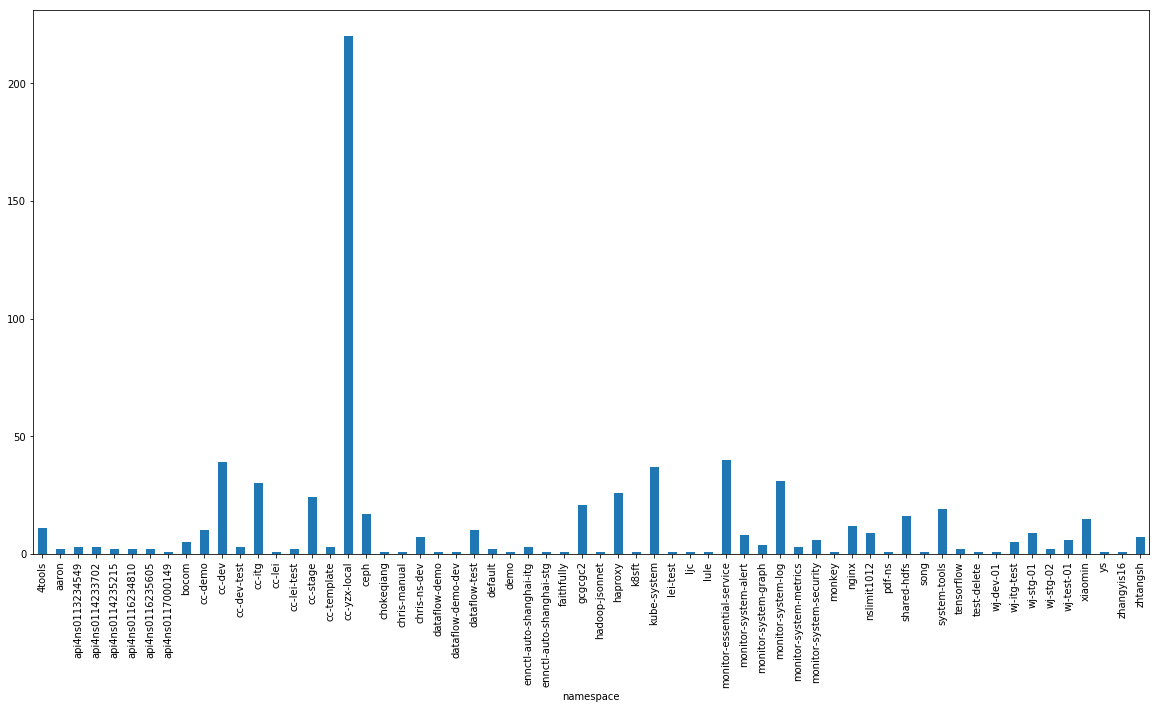

In [44]:
bins = pods['pod'].groupby(['namespace']).size()
bins.plot(kind="bar", figsize=(20,10))


#### plot node resource request percentage

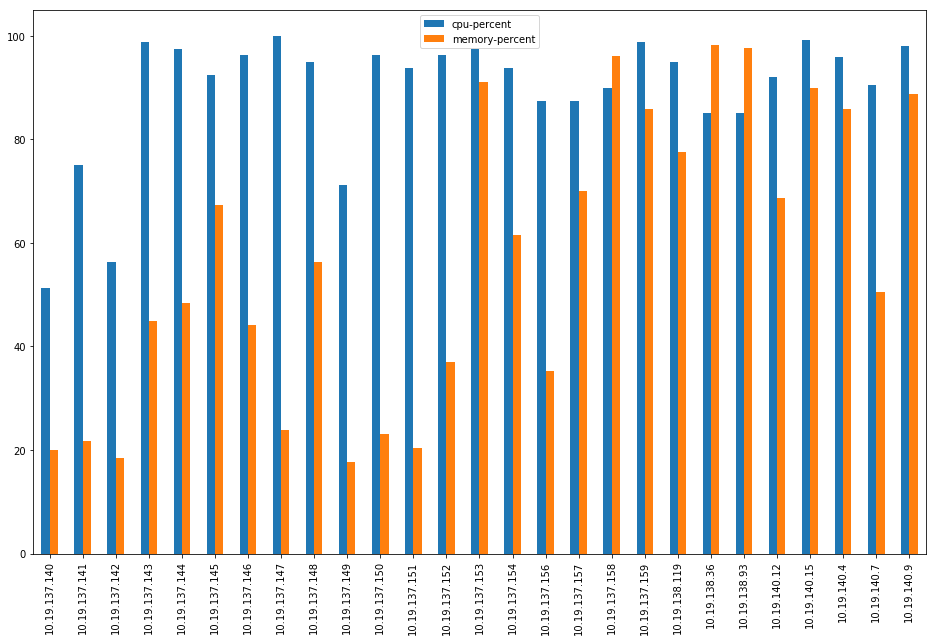

In [2]:
from k8sclient.dataframes import collect_all_pods
pods = collect_all_pods()
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
# runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
runnings = container[(container['phase'] == 'Running')]
# runnings = container
res = runnings[["host_ip", "rcpu", "rmemory",]]# "lcpu", "lmemory", "pod"]]
# res.groupby('host_ip').sum().plot(kind='bar')
# percentage
a = res.groupby('host_ip').sum()
from k8sclient.dataframes import collect_nodes
nodes = collect_nodes().set_index("name")[["a-cpu", "a-memory"]]
b = pd.concat([a, nodes], axis=1)
b["cpu-percent"] = b['rcpu']*100/b['a-cpu']
b["memory-percent"] = b['rmemory']*100/b['a-memory']
b[['cpu-percent', "memory-percent"]].plot(kind='bar', figsize=(16,10))

In [35]:
p = pods['pod'][['namespace', "pod_ip", "pod"]].dropna()
p[p.pod_ip.str.contains("208.4")]

,namespace,pod_ip,pod
381,terminal-perf-4,172.2.208.4,perf-deploy-0-3879083074-d4pdh


In [13]:
# node roles
from k8sclient.dataframes import collect_nodes
nodes = collect_nodes()
nodes[['name', 'role']].set_index('name')

,role
name,
10.19.137.140,master
10.19.137.141,master
10.19.137.142,master
10.19.137.143,ceph
10.19.137.144,ceph
10.19.137.145,ceph
10.19.137.146,ceph
10.19.137.147,application
10.19.137.148,application


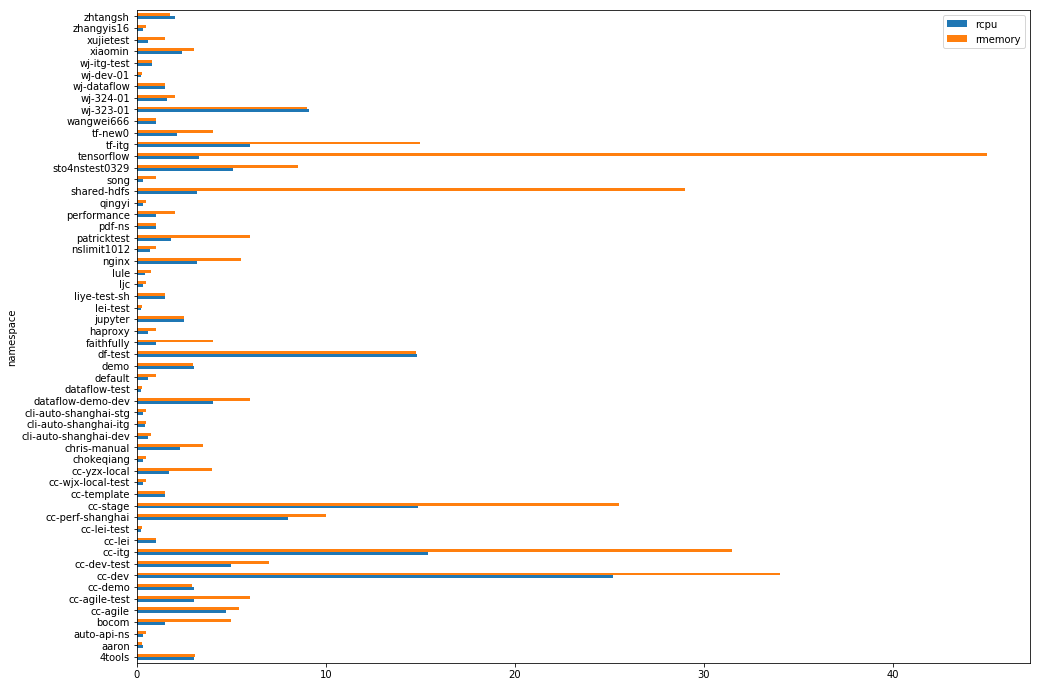

In [14]:
res_namespace = runnings[["namespace", "rcpu", "rmemory",]]
b = res_namespace[~res_namespace.namespace.str.contains("monitor|ceph|kube-system|system-tools")].groupby('namespace').sum()
b[b.rcpu > 0][['rcpu', 'rmemory']].plot(kind='barh', figsize=(16,12))
# b[b.rcpu > 0]['rmemory'].plot(kind='barh', figsize=(12,8))

#### find memory request -ill configured pods

In [11]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
bads = runnings[(runnings.rmemory > 64) | (runnings.lmemory > 64)]
bads[['namespace', "pod", 'rmemory']]

,namespace,pod,rmemory


#### plot running pod per node

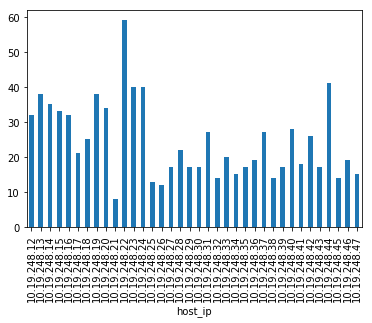

In [31]:
p = pods['pod']
runnings = p[p['phase'] == 'Running']
runnings.groupby('host_ip').size().plot(kind='bar')

#### plot running containers per node

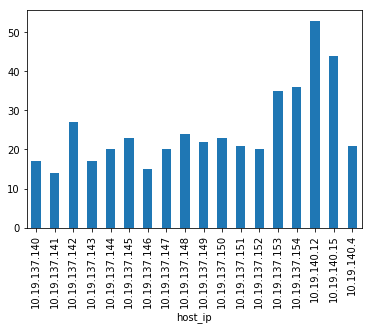

In [13]:
container = pd.merge(pods['pod'], pods['container'], left_on="uid", right_on="pod_id")
runnings = container[(container['state'] == 'running') & (container['phase'] == 'Running')]
runnings.groupby('host_ip').size().plot(kind='bar')

#### read pod logs

In [ ]:
from k8sclient.keywords import tail_pod_logs
r = tail_pod_logs("monitor-essential-service", "elasticsearch-data-734v4", lines=20)
# r.strip().split("\n")
print r

### Node information

In [14]:
from k8sclient.dataframes import collect_nodes
nodes = collect_nodes()
# nodes[["name","a-cpu", "a-memory", "a-pods", "c-cpu", "c-memory", "purpose", "role"]].set_index("name")

In [15]:
nodes[nodes.name=='10.19.248.43'].T

""
DiskPressure
MemoryPressure
OutOfDisk
Ready
a-cpu
a-memory
a-pods
addition
beta.kubernetes.io/arch
beta.kubernetes.io/os


In [16]:
n = nodes.set_index("name")
n[n.nvidiagpu > 0][["a-cpu", "a-memory", "a-pods", "addition", "nvidiagpu"]]

,a-cpu,a-memory,a-pods,addition,nvidiagpu
name,,,,,
10.19.137.147,7.0,60.596355,600,GPU,2
10.19.137.148,7.0,60.596340,600,GPU,2
10.19.137.149,7.0,60.596359,600,GPU,2
10.19.137.150,7.0,60.596359,600,GPU,2
10.19.137.151,7.0,60.596268,600,GPU,2


### Service information

In [42]:
%matplotlib inline
from k8sclient.dataframes import collect_services
services, ports, eips = collect_services()
# services.groupby("type").size().plot(kind="bar")
# services[services['namespace'] == "api4ns1218115431"]
a = pd.merge(services, ports, left_on="uid", right_on="service_id")
a[(a.node_port == "32318") | (a.port == "32318")]

,creation,external_name,name_x,namespace,type,uid,name_y,node_port,port,protocol,service_id,target_port
188,2017-07-21 08:08:40+00:00,None,cc-terminal,cc-itg,NodePort,cea0d064-6deb-11e7-866e-1866da19caf3,None,32318,8818,TCP,cea0d064-6deb-11e7-866e-1866da19caf3,8818
512,2018-01-09 11:38:34+00:00,None,gitbook-svc,faithfully,ClusterIP,9fc99582-f531-11e7-a92f-1866da19caf3,serverport,None,32318,TCP,9fc99582-f531-11e7-a92f-1866da19caf3,4000


#### check conflict external ip ports

In [47]:
import pandas as pd
external_ports = pd.merge(ports, eips)
a = pd.merge(services, external_ports, left_on="uid", right_on="service_id")
b = a[['namespace', "name_x", "type", "port", "target_port", "external_ip"]]
c = b[["external_ip", "port"]].duplicated(keep=False)
# b[c].set_index(["external_ip","port"]).sort_index()
a[a.external_ip.str.contains("140")][['namespace', "name_x", "type", "port", "target_port","external_ip"]]

,namespace,name_x,type,port,target_port,external_ip
7,ccc-hadoop0,demo-namenode1-ex,ClusterIP,52070,50070,10.19.137.140
9,ccc-hadoop0,demo-resourcemanager1-ex,ClusterIP,28088,8088,10.19.137.140
10,ccc-hadoop0,demo-resourcemanager1-ex,ClusterIP,39888,19888,10.19.137.140
13,ccc-hadoop0,demo-zookeeper1-ex,ClusterIP,22181,2181,10.19.137.140
18,cxq9,testissue569,ClusterIP,30485,30485,10.19.137.140
20,dataflow-demo-dev,pre1-kafka1-ex,ClusterIP,29097,9092,10.19.137.140
21,dataflow-demo-dev,pre1-kafka1-ex,ClusterIP,28080,8080,10.19.137.140
22,dataflow-demo-dev,pre1-zookeeper1-ex,ClusterIP,22184,2181,10.19.137.140
32,dataflow-demo-ye,kafka2hdfs,ClusterIP,8180,8180,10.19.137.140
33,dataflow-demo-ye,kafka2hdfs,ClusterIP,8181,8181,10.19.137.140


#### check conflict Nodeport ports

In [19]:
import pandas as pd
a = pd.merge(services, ports, left_on="uid", right_on="service_id")
b = a[['namespace', "name_x", "type", "node_port", "target_port"]]
c = b["node_port"].duplicated(keep=False) & (b.node_port != "None")
b[c].set_index(["node_port"]).sort_index()

,namespace,name_x,type,target_port
node_port,,,,


#### check conflict between nodeport and external ip ports

In [20]:
import pandas as pd
external_ports = pd.merge(ports, eips)
a = pd.merge(services, ports, left_on="uid", right_on="service_id")
node_ports = a[a.type=="NodePort"][['namespace', "name_x", "type", "node_port", "target_port"]]
pd.merge(node_ports, external_ports, left_on="node_port", right_on="port", how="outer").dropna()
# external_ports

,namespace,name_x,type,node_port_x,target_port_x,name,node_port_y,port,protocol,service_id,target_port_y,external_ip


#### plot service type  per namespace

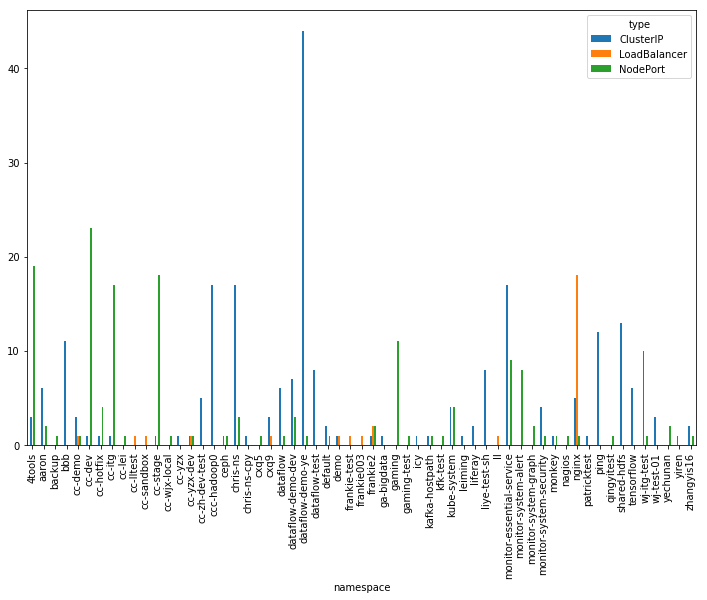

In [21]:
services.groupby(["namespace", "type"]).size().unstack().fillna(0).plot(kind="bar", figsize=(12,8))

In [6]:
#endpoinds
from k8sclient.dataframes import collect_all_endpoints
infos, eps = collect_all_endpoints()

In [21]:
# eps["endpoint_id"]
infos[~infos['uid'].isin(eps["endpoint_id"])]

,creation_timestamp,name,namespace,uid
0,2017-02-08 06:43:12+00:00,dbe-core-serv,4tools,dc97fc47-edc9-11e6-b00c-1866da1a2629
1,2017-02-08 06:45:11+00:00,dbe-listener-serv,4tools,23b66632-edca-11e6-b00c-1866da1a2629
2,2017-02-08 06:27:30+00:00,dbe-mysql-serv,4tools,ab2cdde6-edc7-11e6-b00c-1866da1a2629
3,2016-11-16 09:48:29+00:00,docker-jenkins-svc,4tools,d3d40f20-abe1-11e6-91a0-1866da19caf3
4,2016-11-09 10:51:52+00:00,dokuwiki,4tools,85fc70ee-a66a-11e6-a9e0-1866da19caf3
9,2016-10-31 06:19:40+00:00,heapster,4tools,018c5caa-9f32-11e6-9dbf-1866da19c727
10,2016-09-20 09:45:03+00:00,influxdb,4tools,e7d87273-7f16-11e6-924b-1866da19caf3
11,2016-12-05 06:24:20+00:00,k8s-deploy-api,4tools,74ca376d-bab3-11e6-908a-1866da1a2629
12,2017-01-04 10:53:19+00:00,kube-deploy-server,4tools,00a27caf-d26c-11e6-b0ef-1866da19caf3
15,2016-11-02 02:06:37+00:00,monitoring-grafana,4tools,fc6627f8-a0a0-11e6-9dbf-1866da19c727


## Deployment

### Create pod

In [22]:
from k8sclient.Components import PodBuilder
from k8sclient.keywords import (
    wait_for_pod_state,
    RUNNING,
    delete_pod,
    NOT_FOUND
)

In [ ]:
namespace = "monkey"
image = "127.0.0.1:30100/library/python-tools:v20170619"
args = "loggen.py"
name = "logstress"


def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name,
        image=image,
        args=args,
    ).deploy()
    wait_for_pod_state(namespace, name, 60, RUNNING)


def un_deploy():
    delete_pod(namespace, name)
    wait_for_pod_state(namespace, name, 60, NOT_FOUND)

### Use volumes

In [ ]:
from k8sclient.Components import (
    HostPathVolume, RBDVolume, CephFSVolume, EmptyDirVolume
)
volume_hostpath = HostPathVolume(
        "hostpath-1",
        "/apt/containers",
        "/data/docker/containers"
    )
volume_emptydir = EmptyDirVolume(
    "emptydir-1",
    "/data/something"
)

ceph_monitors = "10.19.137.144:6789,10.19.137.145:6789,10.19.137.146:6789"
ceph_pool = "monkey"
ceph_fstype = "xfs"
ceph_secret = "ceph-secret"
volume_rbd = RBDVolume(
        "rbd",
        "/apt/data",
        fs_type=ceph_fstype,
        image="default",
        pool=ceph_pool,
        monitors=ceph_monitors,
        secret_name=ceph_secret,
        sub_path="writetest",
        read_only=True
    )
volume_cephfs = CephFSVolume(
            "cephfs",
            "/tmp",
            monitors=ceph_monitors,
            secret_name=ceph_secret,
            fs_path="scrapy",
            sub_path="scrapy_name"
        )

def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name,
        image=image,
        args=args,
        volumes=[volume_hostpath, volume_rbd, volume_cephfs, volume_emptydir]
    ).deploy()

### Use service

In [ ]:
from k8sclient.Components import ServicePort, ServiceBuilder

udp_port = ServicePort("dataport", 8125, 8125, protocol="UDP")
http_port = ServicePort("httpport", 80, 80)
udp_service = ServiceBuilder("graphite", namespace).add_port(udp_port)
http_service = ServiceBuilder("graphite-ui", namespace, service_type="NodePort").add_port(http_port)

def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name=name,
        image=image,
        ports=[udp_port, http_port]
    ).attache_service(
        udp_service
    ).attach_service(
        http_service
    ).deploy()

### Env variables

In [ ]:
def deploy():
    PodBuilder(
        name,
        namespace,
    ).add_container(
        name,
        image=image,
        args=args,
        BATCH_SIZE=10000,
        BATCH_COUNT=1000
    ).deploy()

### Node select

In [ ]:
def deploy():
    PodBuilder(
        name,
        namespace,
    ).set_node(
        node
    ).add_container(
        name,
        image=image,
        args=args,
        BATCH_SIZE=10000,
        BATCH_COUNT=1000
    ).deploy()

### Replicaset example

In [26]:
from k8sclient.Components import ServicePort, ServiceBuilder, ReplicaSetBuilder
# from k8sclient.keywords import wait_for_pod_state, RUNNING

namespace = "k8sft"
name = "graphite"
image = "127.0.0.1:30100/yangtze/graphite-statsd"
# ports
udp_port = ServicePort("dataport", 8125, 8125, protocol="UDP")
http_port = ServicePort("httpport", 80, 80)
# service
udp_service = ServiceBuilder("graphite", namespace).add_port(udp_port)
http_service = ServiceBuilder("graphite-ui", namespace, service_type="NodePort").add_port(http_port)
# replica set
rs = ReplicaSetBuilder(
    name, namespace
).add_container(
    name=name + "-container",
    image=image,
    ports=[udp_port, http_port]
).attache_service(
    http_service
).attache_service(
    udp_service
).set_hostname(name)


def deploy():
    rs.deploy()
    udp_service.deploy()
    http_service.deploy()
    


def un_deploy():
    udp_service.un_deploy()
    http_service.un_deploy()
    rs.un_deploy()

un_deploy()

In [24]:
from k8sclient.dataframes import collect_namespaced_services
s, p, e = collect_namespaced_services("k8sft")
p

,name,node_port,port,protocol,service_id,target_port
0,dataport,None,8125,UDP,a4a5b305-8e19-11e7-93f9-1866da1a2629,8125
1,httpport,30804,80,TCP,a4a7832d-8e19-11e7-93f9-1866da1a2629,80


### switch cluster

In [54]:
from k8sclient.keywords import switch_cluster, register_cluster
register_cluster("yancheng", "~/.kube/config-yancheng")
register_cluster("shanghai", "~/.kube/config-shanghai")
#switch_cluster("yancheng")
switch_cluster("shanghai")

In [36]:
memory_fails = """
/sys/fs/cgroup/memory/kubepods/burstable/pod92383ec6-ef9c-11e7-a92f-1866da19caf3/cd6724d7dc7c5902e700d0138b0a491d6cb66ba42144363ccf9b46c703394c33/memory.failcnt 73
/sys/fs/cgroup/memory/kubepods/burstable/pod92383ec6-ef9c-11e7-a92f-1866da19caf3/memory.failcnt 5058604
/sys/fs/cgroup/memory/kubepods/podbba9a8cb-ef9c-11e7-a92f-1866da19caf3/e2535768efebbc54603f3fb3a7d4a04f1b18c2072dbbfd3854591dd3e4f28477/memory.failcnt 2080
/sys/fs/cgroup/memory/kubepods/podbba9a8cb-ef9c-11e7-a92f-1866da19caf3/memory.failcnt 52981616
/sys/fs/cgroup/memory/kubepods/podbde0d7bc-ef9c-11e7-a92f-1866da19caf3/memory.failcnt 5115
/sys/fs/cgroup/memory/kubepods/podbe83c40c-ef9c-11e7-a92f-1866da19caf3/1a29543ccfb0850864e0ca1c61660e0a0665edf152170b542f5f55114ef75524/memory.failcnt 489
/sys/fs/cgroup/memory/kubepods/podbe83c40c-ef9c-11e7-a92f-1866da19caf3/memory.failcnt 57994587
/sys/fs/cgroup/memory/kubepods/burstable/pod3c32fd71-e6bf-11e7-b516-1866da19caf3/memory.failcnt 952801
/sys/fs/cgroup/memory/kubepods/burstable/pod80d1c210-e52c-11e7-b516-1866da19caf3/memory.failcnt 14695
/sys/fs/cgroup/memory/kubepods/pod3dc8fcb0-d8b6-11e7-b516-1866da19caf3/c60773fa4ed1c14f95e963c15676f13e9446016947a8934a2fb581eb7dbaa46c/memory.failcnt 1237
/sys/fs/cgroup/memory/kubepods/pod3dc8fcb0-d8b6-11e7-b516-1866da19caf3/memory.failcnt 144814950
/sys/fs/cgroup/memory/kubepods/burstable/pod6d124f09-e564-11e7-b516-1866da19caf3/2d9ec3a0fbb97827ccf4487d96f21c183538efcf1fc14b762c11d7566baa2479/memory.failcnt 1
/sys/fs/cgroup/memory/kubepods/burstable/pod6d124f09-e564-11e7-b516-1866da19caf3/memory.failcnt 59751
/sys/fs/cgroup/memory/kubepods/burstable/pod8f2d8183-e62e-11e7-b516-1866da19caf3/bbebceebc96e4917bcb45985faf6f6427d1fe62deaf1507ae284a7cbf9055001/memory.failcnt 5
/sys/fs/cgroup/memory/kubepods/burstable/pod8f2d8183-e62e-11e7-b516-1866da19caf3/memory.failcnt 60869
/sys/fs/cgroup/memory/kubepods/burstable/poda5ac79e8-e6b4-11e7-b516-1866da19caf3/b9b6e635654cc15cffa8dbbda2162751b7501c32cbc186702e741bfa2b334a7e/memory.failcnt 83
/sys/fs/cgroup/memory/kubepods/burstable/poda5ac79e8-e6b4-11e7-b516-1866da19caf3/memory.failcnt 764237
/sys/fs/cgroup/memory/kubepods/burstable/podaf6534b9-f030-11e7-a92f-1866da19caf3/93ebe27dce4d6c3ef933b1979ca64e3b804b1d9d22a0e45ec5e22b0082c23015/memory.failcnt 18
/sys/fs/cgroup/memory/kubepods/burstable/podaf6534b9-f030-11e7-a92f-1866da19caf3/memory.failcnt 10710048
/sys/fs/cgroup/memory/kubepods/burstable/pod89b9e642-e6b6-11e7-b516-1866da19caf3/61bbd4ada5fa0407cda97241e2372428ffc26545913e6e79f330b621f54e2933/memory.failcnt 290
/sys/fs/cgroup/memory/kubepods/burstable/pod89b9e642-e6b6-11e7-b516-1866da19caf3/memory.failcnt 874218
/sys/fs/cgroup/memory/kubepods/burstable/podb84c88ea-f245-11e7-a92f-1866da19caf3/memory.failcnt 6771
/sys/fs/cgroup/memory/kubepods/burstable/podaf653089-f030-11e7-a92f-1866da19caf3/fbcc7b6897c9705b4c743143767e0c324a5bc3fbd5d59a2b45c55cc93aabe54a/memory.failcnt 1
/sys/fs/cgroup/memory/kubepods/burstable/podaf653089-f030-11e7-a92f-1866da19caf3/memory.failcnt 4308286
/sys/fs/cgroup/memory/kubepods/burstable/podaf6526c5-f030-11e7-a92f-1866da19caf3/d009620c69e2086199c24ee4a34abd7f0ead0af059685c7145a213571c41562c/memory.failcnt 3
/sys/fs/cgroup/memory/kubepods/burstable/podaf6526c5-f030-11e7-a92f-1866da19caf3/memory.failcnt 165484
/sys/fs/cgroup/memory/kubepods/burstable/podaf652ab8-f030-11e7-a92f-1866da19caf3/8669baeed51e8d72153e2bfc1b17e01594051b7e798e8c3513ae4e645dcf733c/memory.failcnt 2
/sys/fs/cgroup/memory/kubepods/burstable/podaf652ab8-f030-11e7-a92f-1866da19caf3/memory.failcnt 6603293
/sys/fs/cgroup/memory/kubepods/burstable/podaf651e58-f030-11e7-a92f-1866da19caf3/1bb7aaba108afd4c5928e3ef386e0810c2f39556eadb4f6c89f098c3ac10f40e/memory.failcnt 3
/sys/fs/cgroup/memory/kubepods/burstable/podaf651e58-f030-11e7-a92f-1866da19caf3/memory.failcnt 13825646
/sys/fs/cgroup/memory/kubepods/burstable/pod05c4bd3f-db73-11e7-b516-1866da19caf3/7da6f90c1f8e3308f2ed682d4e4bb541aab5059a57430f5add9ef367100d4857/memory.failcnt 253
/sys/fs/cgroup/memory/kubepods/burstable/pod05c4bd3f-db73-11e7-b516-1866da19caf3/memory.failcnt 56524524
/sys/fs/cgroup/memory/kubepods/burstable/podf3d5464c-efa3-11e7-a92f-1866da19caf3/aac5dbf82d16b1239487cd547bcb2164615b5e3bdc0f7d4472956331af4a2228/memory.failcnt 21
/sys/fs/cgroup/memory/kubepods/burstable/podf3d5464c-efa3-11e7-a92f-1866da19caf3/memory.failcnt 5737769
/sys/fs/cgroup/memory/kubepods/burstable/pod3c331bae-e6bf-11e7-b516-1866da19caf3/memory.failcnt 223327
/sys/fs/cgroup/memory/kubepods/burstable/podb86b2641-f245-11e7-a92f-1866da19caf3/99e46b5cb3755b5972a0f76a347ec16b8f1bfa6341fa4b3dd1b763c7d012171c/memory.failcnt 25
/sys/fs/cgroup/memory/kubepods/burstable/podb86b2641-f245-11e7-a92f-1866da19caf3/memory.failcnt 4709673
/sys/fs/cgroup/memory/kubepods/burstable/podf89e023e-f038-11e7-a92f-1866da19caf3/b902852e869b35717d60e99ad2a5c8476aecd25915549326f95cac1534aa3d33/memory.failcnt 43
/sys/fs/cgroup/memory/kubepods/burstable/podf89e023e-f038-11e7-a92f-1866da19caf3/memory.failcnt 5741312
/sys/fs/cgroup/memory/kubepods/burstable/pode20504b6-f2dc-11e7-a92f-1866da19caf3/4cb94a25d2d9171c372996bc4c8a6c0ab4535bfb4fba6a45aa8f926b18c22545/memory.failcnt 142
/sys/fs/cgroup/memory/kubepods/burstable/pode20504b6-f2dc-11e7-a92f-1866da19caf3/memory.failcnt 11186669
/sys/fs/cgroup/memory/kubepods/burstable/poda81c82a4-ef99-11e7-a92f-1866da19caf3/memory.failcnt 876345
/sys/fs/cgroup/memory/kubepods/burstable/podaf652063-f030-11e7-a92f-1866da19caf3/f52bafdc92c6221bb1126c6d9eff1a76c33875bf359d1419acb923d671075120/memory.failcnt 18
/sys/fs/cgroup/memory/kubepods/burstable/podaf652063-f030-11e7-a92f-1866da19caf3/memory.failcnt 7567886
/sys/fs/cgroup/memory/kubepods/burstable/podaf653a1b-f030-11e7-a92f-1866da19caf3/da217e70746fc05fa6802dd6dd83f523c4ed4b39ee453a7e3e83a891d2459704/memory.failcnt 2
/sys/fs/cgroup/memory/kubepods/burstable/podaf653a1b-f030-11e7-a92f-1866da19caf3/memory.failcnt 5158703
/sys/fs/cgroup/memory/kubepods/burstable/podfa74f232-efa3-11e7-a92f-1866da19caf3/aecc745a9df9ea72eb4dcf5d5a8c2775bc9020b79b461a0a2b35527bda755e5b/memory.failcnt 4
/sys/fs/cgroup/memory/kubepods/burstable/podfa74f232-efa3-11e7-a92f-1866da19caf3/memory.failcnt 8404024
/sys/fs/cgroup/memory/kubepods/burstable/poda80d4094-ef99-11e7-a92f-1866da19caf3/0fbb8453e57b752813f28a6394615f45f8b72d873b492f718b265291e0e97861/memory.failcnt 299
/sys/fs/cgroup/memory/kubepods/burstable/poda80d4094-ef99-11e7-a92f-1866da19caf3/memory.failcnt 20785
/sys/fs/cgroup/memory/kubepods/burstable/pod238b9a79-ef9f-11e7-a92f-1866da19caf3/memory.failcnt 267
/sys/fs/cgroup/memory/kubepods/burstable/pod18d6ea8a-ef9f-11e7-a92f-1866da19caf3/memory.failcnt 13542
/sys/fs/cgroup/memory/kubepods/burstable/podaf653bbe-f030-11e7-a92f-1866da19caf3/memory.failcnt 4525920
/sys/fs/cgroup/memory/kubepods/burstable/podaf653bbe-f030-11e7-a92f-1866da19caf3/fbc3cfa348597d2590db22a99aa6f70d97cbea754f30f5071b5b64f3a067e611/memory.failcnt 4
/sys/fs/cgroup/memory/kubepods/burstable/poda30c1d2f-ef99-11e7-a92f-1866da19caf3/memory.failcnt 10340703
/sys/fs/cgroup/memory/kubepods/burstable/poda30c1d2f-ef99-11e7-a92f-1866da19caf3/248cd0e04462e1225360b3a676155921f8fa33fcead938540611913191d4b14b/memory.failcnt 15
/sys/fs/cgroup/memory/kubepods/burstable/podaf6524b8-f030-11e7-a92f-1866da19caf3/746eaf4ba60be56b97d311172025aa5fd2688f28f2acee0bd5f604071d015705/memory.failcnt 30
/sys/fs/cgroup/memory/kubepods/burstable/podaf6524b8-f030-11e7-a92f-1866da19caf3/memory.failcnt 4750710
/sys/fs/cgroup/memory/kubepods/burstable/podbeb06336-f06c-11e7-a92f-1866da19caf3/0670e474f474dcc6a2775457a5df41b3d396cc9db09e254999f07001aad0672e/memory.failcnt 14
/sys/fs/cgroup/memory/kubepods/burstable/podbeb06336-f06c-11e7-a92f-1866da19caf3/memory.failcnt 9261
/sys/fs/cgroup/memory/kubepods/burstable/podd8143c3f-ef9e-11e7-a92f-1866da19caf3/memory.failcnt 119462
/sys/fs/cgroup/memory/kubepods/burstable/pod5dd04652-f1df-11e7-a92f-1866da19caf3/memory.failcnt 1195
/sys/fs/cgroup/memory/kubepods/burstable/pod52bcc254-f1e7-11e7-a92f-1866da19caf3/4ab43b9d3a5fe10952599f0eef6f5c29b7bff1b2e173333e9fb0db1317007756/memory.failcnt 10
/sys/fs/cgroup/memory/kubepods/burstable/pod52bcc254-f1e7-11e7-a92f-1866da19caf3/memory.failcnt 78
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-podaf6517da_f030_11e7_a92f_1866da19caf3.slice/memory.failcnt 3339245
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod774cbbe6_eab5_11e7_b516_1866da19caf3.slice/docker-58b781c23156b401816292711101745fb01347cba86e6837ba91b7209bfa9e47.scope/memory.failcnt 1530919
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod774cbbe6_eab5_11e7_b516_1866da19caf3.slice/memory.failcnt 43181
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-podaf652e64_f030_11e7_a92f_1866da19caf3.slice/docker-dd66d4dfb76ea11de11b2f1cdf2fd45f89497e5551ac466b649bb514486ae741.scope/memory.failcnt 3074716
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-podaf652e64_f030_11e7_a92f_1866da19caf3.slice/memory.failcnt 2481544
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-poda7c91226_ef99_11e7_a92f_1866da19caf3.slice/memory.failcnt 41057
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-podaf6541db_f030_11e7_a92f_1866da19caf3.slice/docker-91c883318c7d3503275470cf46de285e00b6d9b6ae4d0318f5d76c4e0c12893b.scope/memory.failcnt 5934886
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-podaf6541db_f030_11e7_a92f_1866da19caf3.slice/memory.failcnt 4877615
/sys/fs/cgroup/memory/kubepods.slice/kubepods-burstable.slice/kubepods-burstable-pod77514dac_eab5_11e7_b516_1866da19caf3.slice/memory.failcnt 17164
"""
import re
p = re.compile(".*pod([-_a-z0-9]{36}).* (\d+)")
d = []
for i in p.findall(memory_fails):
    d.append((i[0].replace('_', '-'), int(i[1])))
failcnt = pd.DataFrame(d, columns=['id', 'memory.failcnt'])
failcnt
# from k8sclient.dataframes import collect_all_pods
# pods = collect_all_pods()
# pods['container']
# podids = [i for i in raw.split("\n") if not i.startswith("10.19")]
pd.options.display.float_format = '{:,.1f}G'.format
p1 = pd.merge(pods['pod'], failcnt, left_on="uid", right_on="id")
p2 = pd.merge(p1, pods['container'], left_on="uid", right_on="pod_id")
pp = p2[['namespace', 'pod', 'memory.failcnt', 'lmemory', 'pod_id']]
pp.sort_values(by='memory.failcnt', ascending=False)
# p3 = pods['container']
# p3[p3.pod_id=='774cbbe6-eab5-11e7-b516-1866da19caf3']
# pp[pp.namespace=='4tools']


,namespace,pod,memory.failcnt,lmemory,pod_id
50,monitor-essential-service,k3-jh00d,144814950,2.0G,3dc8fcb0-d8b6-11e7-b516-1866da19caf3
48,monitor-essential-service,k2-11lwz,57994587,2.0G,be83c40c-ef9c-11e7-a92f-1866da19caf3
60,shared-hdfs,pre1-datanode-2117003372-g55qx,56524524,8.0G,05c4bd3f-db73-11e7-b516-1866da19caf3
46,monitor-essential-service,k1-9zbk7,52981616,2.0G,bba9a8cb-ef9c-11e7-a92f-1866da19caf3
21,monitor-essential-service,elasticsearch-data-1cv3k,13825646,16.0G,af651e58-f030-11e7-a92f-1866da19caf3
34,monitor-essential-service,elasticsearch-data-f90j8,11186669,16.0G,e20504b6-f2dc-11e7-a92f-1866da19caf3
42,monitor-essential-service,elasticsearch-data-rgm49,10710048,16.0G,af6534b9-f030-11e7-a92f-1866da19caf3
55,shared-hdfs,pre1-datanode-2117003372-bk0rf,10340703,8.0G,a30c1d2f-ef99-11e7-a92f-1866da19caf3
62,shared-hdfs,pre1-datanode-2117003372-kdxcf,8404024,8.0G,fa74f232-efa3-11e7-a92f-1866da19caf3
29,monitor-essential-service,elasticsearch-data-8sq3j,7567886,16.0G,af652063-f030-11e7-a92f-1866da19caf3
